In [2]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
from src.preprocessing.load_data import *
from src.preprocessing.process_softchirp_features import find_outliers, choose_features
from src.data_representations.softchirp_features import compute_all_features
from src.data_representations.process_traces import clear_trace
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.visualization.plot_softchirps import plot
from src.util import delete_indexes
import src.visualization.plot_softchirps
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS # change plotting_config file to change colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

def load_traces_wavs_and_metadata(recs_metadata, info=None, recs_dict = None, filter_wavs=True,
                                  sr=22050):
    """ Loads traces and sounds for recordings in recs metadata. 
        If recording_dict is provided (dict{rec_name : rec_wav}) recordings will taken from it,
        otherwise, the rec_dict will be loaded"""
    traces, wavs, sounds_metadata,  = [], [], []
    if recs_dict is None:
        recs_dict = load_recs_dict(recs_metadata)
        
    for (rec_name, rec_path, colony, 
         date, ratids, exp) in recs_metadata[['name', 'path', 'colony', 'date', 'ratids', 'experiment']].values:

        path_to_traces = rec_path.replace('recordings', 'traces')
        rec_traces = [t for t in os.listdir(path_to_traces) if rec_name[:-3] in t]
        for tr_name in rec_traces:
            tr = plt.imread(path_to_traces + tr_name)
            traces.append(tr)
            s, e = map(lambda x: int(sr * float(x)), 
                       re.findall('[0-9]+\.[0-9]+\_[0-9]+\.[0-9]+', tr_name)[0].split('_'))
            cl = re.findall('_[a-z]+_', tr_name)[0][1 : -1]
            wav = recs_dict[rec_name][s : e]
            if filter_wavs:
                wav = butter_highpass_filter(wav, int(sr/7.35), sr)
            wavs.append(wav)
            sounds_metadata.append((rec_name, colony, date, ratids, exp, s / sr, e / sr, cl))
    
    sounds_metadata = pd.DataFrame(sounds_metadata, columns = ['rec', 'colony', 'date', 'ratids', 
                                                               'experiment', 's', 'e', 'cl'])
    return traces, wavs, sounds_metadata

In [49]:
# specify paths, where data is stored
path_to_info = None
path_to_recordings_metadata = PATH_TO_PROJECT + 'mice_data_examples/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = 'all'
#colonies = 'all'
dates = 'all'
experiments = 'all'
stages = ['traced']

# specifies seconds to pixels ratio for spectrogram image
# uses librosa library which downsamples all audio files to 22050
freq_mult = 250000 / 2  / 128

# specify outliers,soft chirp traces outside of these ranges are excluded from analysis  
boundaries = {
              'frequency' : (60000, 200000), 
              'duration' : (0.001, 1),
             }

In [10]:
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})
# filter what will be used (this is specified above)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_to_analyse = recs_metadata[mask]
recs_dict = load_recs_dict(recs_to_analyse)
traces, wavs, sounds_metadata = load_traces_wavs_and_metadata(recs_to_analyse, recs_dict= recs_dict,
                                                              sr=250000, filter_wavs=False)
traces = [clear_trace(t, ) for t in traces]
# compute softchirp features
features, inds_skipped = compute_all_features(traces, wavs, freq_mult)
traces, wavs, sounds_metadata = delete_indexes(inds_skipped, traces, wavs, sounds_metadata)
boundaries = {
              'frequency' : (60000, 200000), 
              'duration' : (0.001, 1),
             }

# remove outliers
outliers = find_outliers(features, boundaries )
features, sounds_metadata = delete_indexes(outliers, features, sounds_metadata)
print('Features could not be extracted from %d traces' % len(inds_skipped))
print('%d traces were deleted as outliers' %  len(outliers))
print('%d traces are left' % (len(sounds_metadata)))

/home/gr1/tf2.1/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [60]:
print(features.columns)

Index(['slope', 'frequency', 'pitch', 'amplitude', 'wiener_entropy',
       'zero_crossings', 'duration', 'height', 'asymmetry'],
      dtype='object')


Keys:  ['rec', 'colony', 'date', 'ratids', 'experiment', 's', 'e', 'cl']


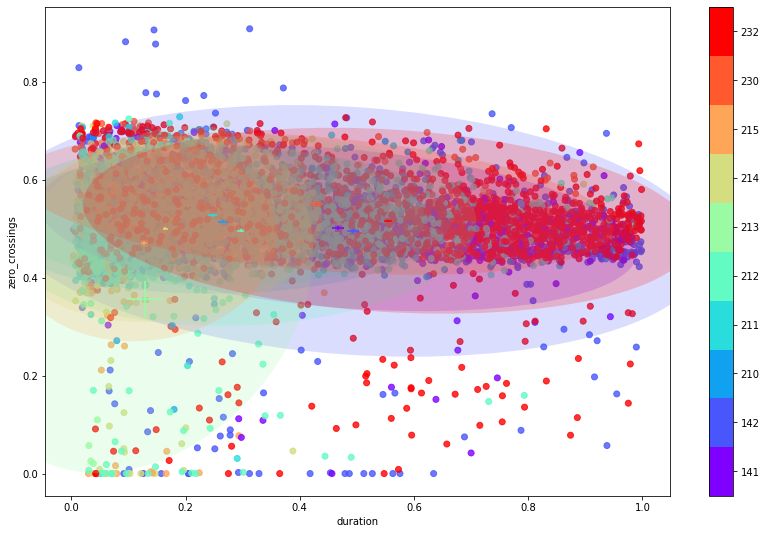

In [62]:

# specify what is ploted
print('Keys: ', list(sounds_metadata.columns))
# specify filters
colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' # options: 'M', 'F', or 'all'
ages = 'all' # set range: (0, np.inf)
ranks = 'all' 
ratids =  'all'
excludeids = None # options: '1111', or None
bodylengths = 'all'# or set range
bodylengths2 = 'all' # or set range
sounds_per_rat = 'all'
types = 'all'# options for types: 'single', 'pairs', or 'all'

# how to plot
color_by = 'ratids' #specfies color option in graph
#options = 'colony', 'age', 'weight'
features_to_plot = ['duration', 'zero_crossings']
#features_to_plot = 'pca' #can make PCA ot tSNE plots of all features
perplexity = 50 #only required for tSNE

group_by_rat = False # plots mean values for each animal
plot_color_mean = True # plots mean for color_by grouping (i.e. colony)
group_color_column = None
plot_ellipses = True # plots ellipses representing 95% confidence intervals


order = ORDER[color_by]
color_dict = COLOR[color_by]


mask =  filter_sounds_metadata_extended(sounds_metadata, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
features_masked = features[mask]
sounds_metadata_masked = sounds_metadata[mask]
y = sounds_metadata_masked[color_by]


plot(features_masked, y, sounds_metadata_masked, features_to_plot, perplexity,
     group_by_rat, group_color_column, plot_ellipses, plot_color_mean,
     color_dict, order, sizes_factor = 32)